<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Clustering</center></h2>

In [ ]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

RND_SEED = 123
plt.style.use('ggplot')

numpy.random.seed(RND_SEED)

%matplotlib inline

# Применение K-means

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [ ]:
df_sns = pd.read_csv('data/snsdata.csv', sep=',')
df_sns.head()

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [ ]:
## Your Code Here

## Иерархическая кластеризация: Пищевая ценность продуктов

Загрузите файл `food.txt`. В нем содержится информация о пищевой ценности разных продуктов

In [ ]:
df = pd.read_csv('data/food.txt', sep=' ')
df.head()

* Подготовте данные к кластеризации 
    * Выделите признаки в матрицу X (numpy array)
    * Отнормируйте признаки

* Произведите иерарническую кластеризацию этого набора данных (метод `linkage`)
* Выберите тип пересчета расстояния между кластерами с помощью кофенетической корреляции

In [ ]:
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage, cophenet

* Изобразите дендрограмму
    * Сначала просто посмотрите на результат метода `dendrogram`
    * Сделаем визуализацию более наглядной:
        * Выделите названия продуктов в numpy array c названием `names`
        * Выполните `dendrogram`  аргументами `orientation='left'`, `labels=names`
        * Теперь мы должны увидеть, что дендрограмма транспонировалась и вместо безымянных индексов мы имеем наименования объектов

* Выделите кластеры по дендрограмме с помощью метода `fcluster`
    * Наличие кластеров, состоящих из одного объекта - нормальное явление, если это можно объяснить

## DBSCAN: Геоданные

In [ ]:
import mpl_toolkits.basemap as bm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Загрузите геоданные из `geo_data.txt` (lat, lon).

Будем пытаться кластеризовать данные с помощью DBSCAN и меры [haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [ ]:
df_geo = pd.read_csv('data/geo_data.txt', sep='\t', header=None,
                     names=['lat', 'lon'])/10000

In [ ]:
df_geo.head()

In [16]:
def plot_geo(lat, lon, labels=None):    
    try:
        lllat, lllon = lat.min()-1, lon.max()+1
        urlat, urlon = lat.max()+1, lon.min()-1

        plt.figure(figsize=(10, 10))

        m = bm.Basemap(
            llcrnrlon=lllon,
            llcrnrlat=lllat,
            urcrnrlon=urlon,
            urcrnrlat=urlat, 
            projection='merc',
            resolution='h'
        )

        m.drawcoastlines(linewidth=0.5)
        m.drawmapboundary(fill_color='#47A4C9', zorder=1)
        m.fillcontinents(color='#EBC4D8',lake_color='#47A4C9', zorder=2)

        parallels = np.linspace(lllat, urlat, 10)
        m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
        # draw meridians
        meridians = np.linspace(urlon, lllon, 10)
        m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

        m.scatter(lon, lat, latlon=True, cmap=plt.cm.jet,
              zorder=3, lw=0, c=labels)
    except:
        print('что-то пошло не так')
        plt.scatter(x=lon, y=lat, c=labels, cmap=plt.cm.jet)
        plt.axis('equal')

Для начала нарисуем все точки на карте

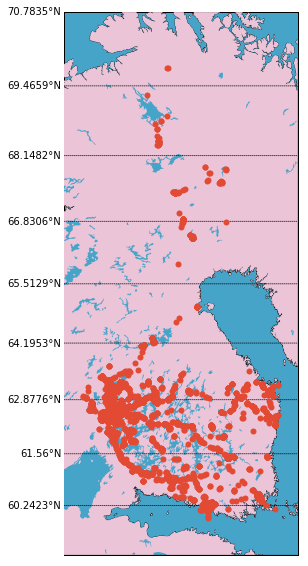

In [18]:
plot_geo(df_geo.loc[:, 'lat'].values, df_geo.loc[:, 'lon'].values)

Это данные с check-in людей в foursquare. В данных могут быть ошибки и просто непопулярные заведения.

Мы будем использовать расстояние haversine - на входе требуются координаты в **радианах**. Выход тоже будет в радианах. Чтобы перейти от градусов в радианты мы можем вспомнить тригонометрию, а можем воспользоваться функцией `np.radians`.

Для кого, чтобы не терять связь с реальностью, будем иметь ввиду, что расстояние в 1 радиан на земном шаре равно примерно 6371.0088 километрам.

Создайте матрицу X с координатами в радианах

In [ ]:
km_in_radian = 6371.0088
X = np.radians(df_geo.values)

Как же определить, какие параметры для DBSCAN выставлять? Наибольшую проблемы представляет параметр eps.

Будем считать, что MinPts нам дан свыше  например для себя мы определили, что кластером будет считаться группа из **минимум** 20 точек - MinPts = 20). Воспользуемся следующим способом оценки:

* Расчитайте расстояние до k=MinPts ближайшего соседа каждой точки (класс `NearestNeighbors` и метод `kneighbors`)
* Отсортируйте полученный массив и выведите его на график
* По графику будет примерно понятно, сколько точек уйдет в шум, а сколько попадет в полноценный кластер при всевозможных `eps`
* Выберите eps, при котором график начинает "уходить вверх" (примерно 0.02-0.06, если все было сделано верно)

In [ ]:
nn = NearestNeighbors()


Определим eps мы можем начать кластеризацию

* Создайте экземпляр класса DBSCAN, кластеризуйте данные
* Выведите полученные метки кластеров и их частоты
* Интерпретировать кластеры может оказаться затруднительно, но можно избавить от выборов и посмотреть на результат
    * Изобразите координаты точек, не попавших в кластер выбросов (метка -1) 